# House Price Prediction (Linear Regression & Decision Tree Regression)

## Context
Data source, goal, etc

## To do List:
1. Go back and preprocess the data properly, dummy variables before scaling and consider whether or not categorical values need to be scaled because they probably don't/shouldn't be scaled.
2. Output of the estimated coefficients?
3. Some kind of plot of the model's performance? How might I do this with multiple input variables 


## Set up

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

sns.set()

In [2]:
data = pd.read_csv("../data/kc_house_data.csv")
data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,condition
0,221900.0,3,1.00,1180,5650,1.0,7,1180,0,1955,0,47.5112,-122.257,1340,5650,3
1,538000.0,3,2.25,2570,7242,2.0,7,2170,400,1951,1991,47.7210,-122.319,1690,7639,3
2,180000.0,2,1.00,770,10000,1.0,6,770,0,1933,0,47.7379,-122.233,2720,8062,3
3,604000.0,4,3.00,1960,5000,1.0,7,1050,910,1965,0,47.5208,-122.393,1360,5000,5
4,510000.0,3,2.00,1680,8080,1.0,8,1680,0,1987,0,47.6168,-122.045,1800,7503,3


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21613 non-null  float64
 1   bedrooms       21613 non-null  int64  
 2   bathrooms      21613 non-null  float64
 3   sqft_living    21613 non-null  int64  
 4   sqft_lot       21613 non-null  int64  
 5   floors         21613 non-null  float64
 6   grade          21613 non-null  int64  
 7   sqft_above     21613 non-null  int64  
 8   sqft_basement  21613 non-null  int64  
 9   yr_built       21613 non-null  int64  
 10  yr_renovated   21613 non-null  int64  
 11  lat            21613 non-null  float64
 12  long           21613 non-null  float64
 13  sqft_living15  21613 non-null  int64  
 14  sqft_lot15     21613 non-null  int64  
 15  condition      21613 non-null  int64  
dtypes: float64(5), int64(11)
memory usage: 2.6 MB


In [4]:
data.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,condition
count,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,5.401822e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,7.656873,1788.390691,291.509045,1971.005136,84.402258,47.560053,-122.213896,1986.552492,12768.455652,3.409430
std,3.673622e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,1.175459,828.090978,442.575043,29.373411,401.679240,0.138564,0.140828,685.391304,27304.179631,0.650743
min,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,47.155900,-122.519000,399.000000,651.000000,1.000000
25%,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,47.471000,-122.328000,1490.000000,5100.000000,3.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,7.000000,1560.000000,0.000000,1975.000000,0.000000,47.571800,-122.230000,1840.000000,7620.000000,3.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,47.678000,-122.125000,2360.000000,10083.000000,4.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,47.777600,-121.315000,6210.000000,871200.000000,5.000000


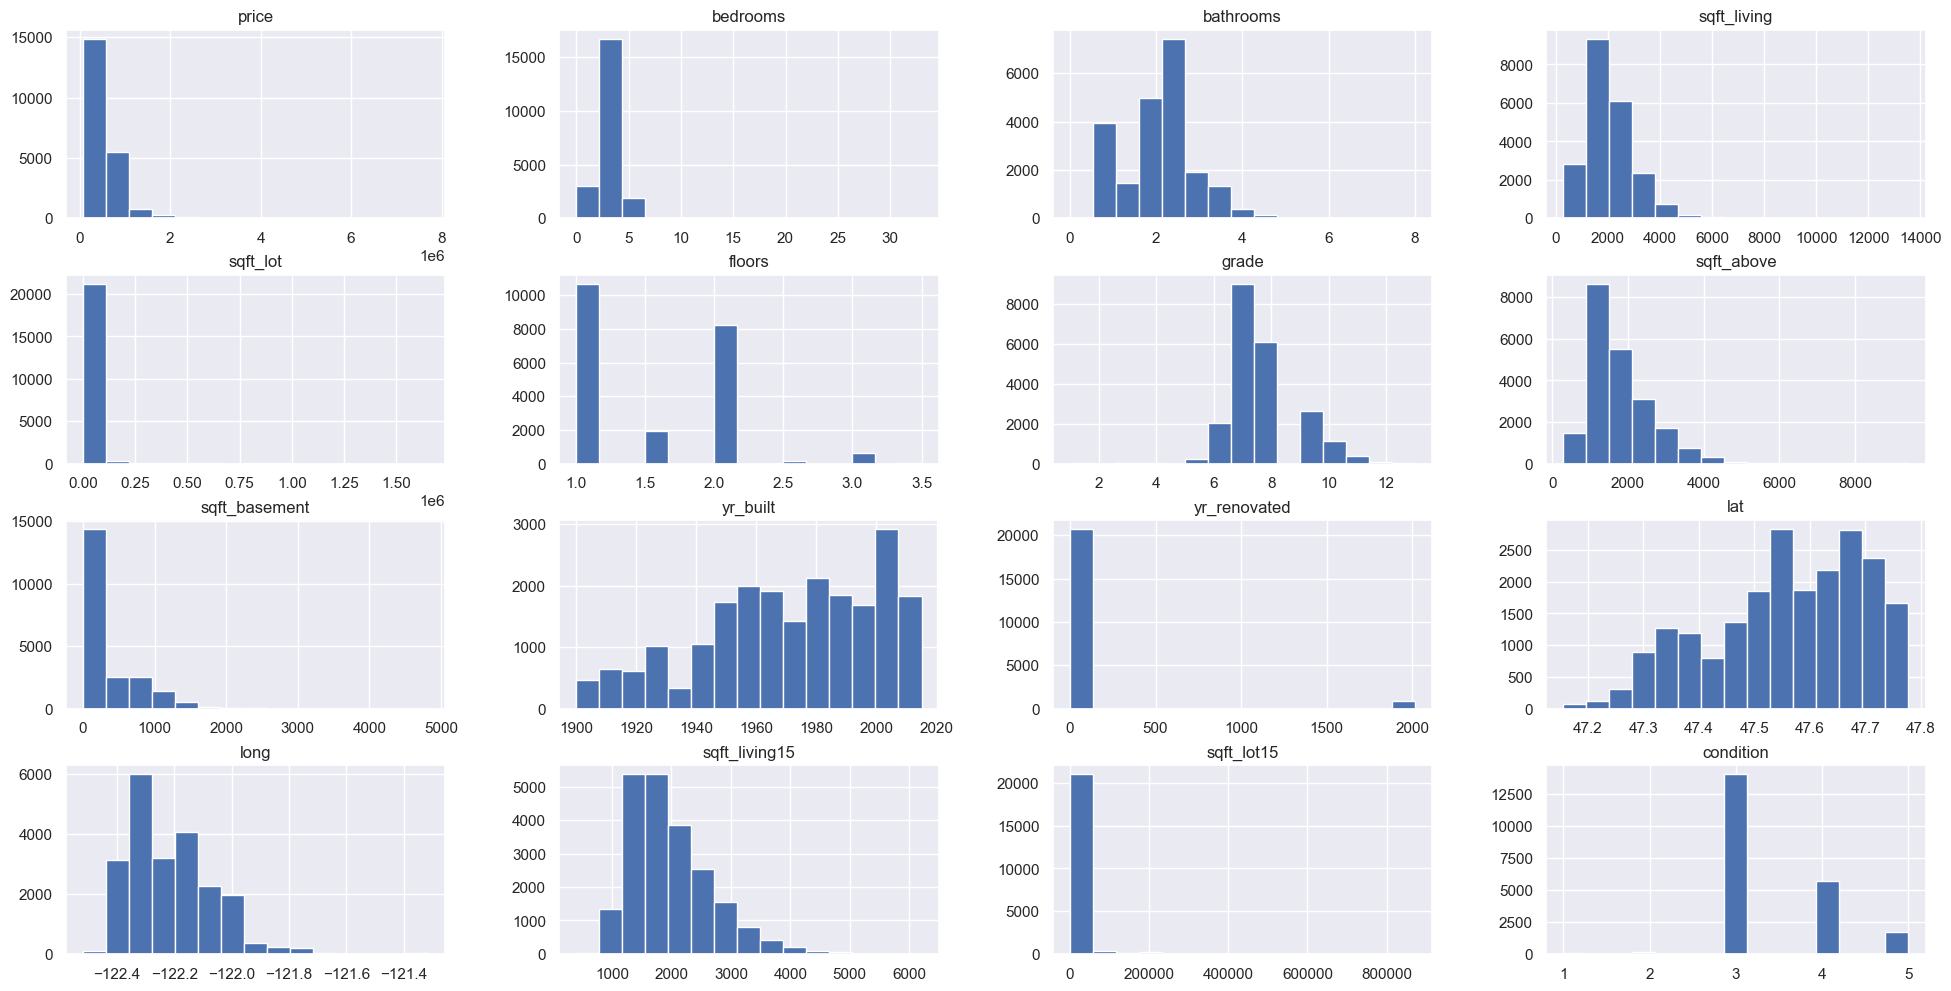

In [5]:
data.hist(bins=15, figsize=(24,12));

In [6]:
# Train test split before any further exploration to avoid any "data snooping" bias
train_set, test_set = train_test_split(data, test_size=0.2, shuffle=True, random_state=42)
price_df = train_set.copy()

## EDA

In [7]:
# Quick use function that will plot a number of scatter plots against price, depending on the range of columns I pass
def plot_scatter(col_start=1, col_stop=4):
    fig, axs = plt.subplots(1, (col_stop-col_start+1), figsize=(50,10))
    
    plot_cols = price_df.columns[col_start:col_stop+1]
    
    for i, col in enumerate(plot_cols):
        sns.scatterplot(data=price_df,
                        x=col,
                        y='price',
                        ax=axs[i])

''

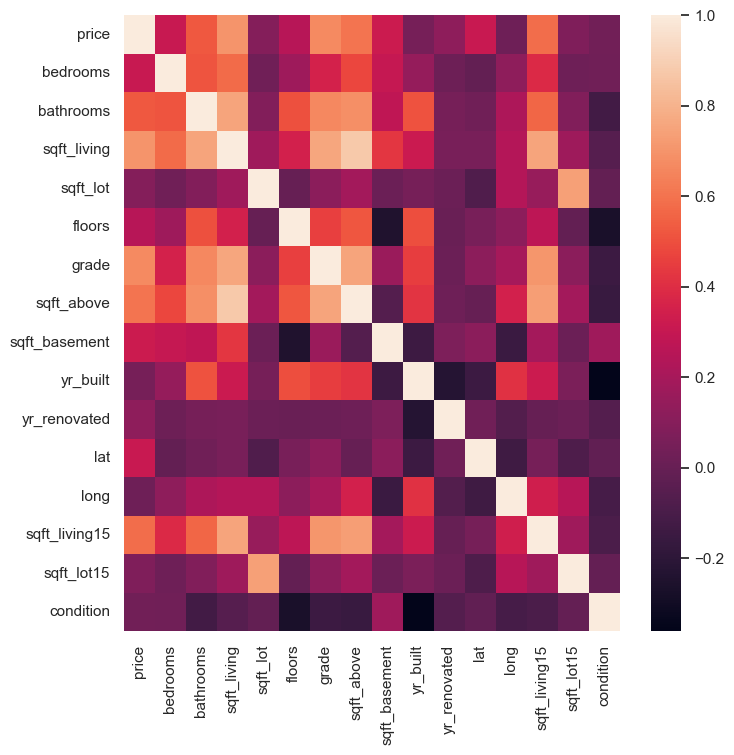

In [8]:
# Quick look at potentially interesting linear relationships
plt.figure(figsize=(8,8))
sns.heatmap(price_df.corr())
;

''

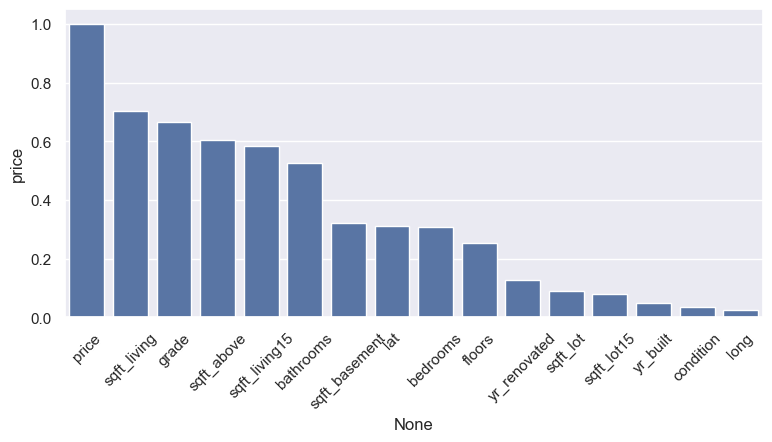

In [9]:
# Ordered bar chart of Pearson correlation coefs
corr_matrix = price_df.corr()[['price']].sort_values('price', ascending=False)

plt.subplots(figsize=(9,4))
plt.xticks(rotation=45)

sns.barplot(x=corr_matrix.index, y=corr_matrix['price'])
;

<Axes: xlabel='sqft_living', ylabel='price'>

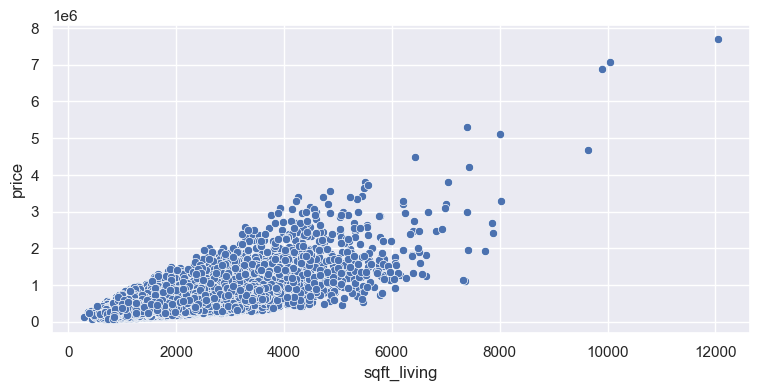

In [10]:
plt.figure(figsize=(9,4))

sns.scatterplot(data=price_df,
               x='sqft_living',
               y='price')

## Preprocessing & Feature Engineering

In [11]:
X = price_df.drop('price', axis=1) 
y = price_df[['price']]

scaled_X = StandardScaler().fit_transform(X)

## Baseline Model
- Do I use the Ridge and Lasso with cross_val_score or do I simply use RidgeCV and LassoCV?

In [12]:
lasso_reg = Lasso(max_iter=1_000)
cross_val = KFold(n_splits=5, shuffle=True, random_state=42)

In [13]:
# K-fold validation with 5 folds and MSE as the error metric
lasso_scores_mse = cross_val_score(estimator=lasso_reg, 
                                   X=scaled_X,
                                   y=y,
                                   scoring='neg_mean_squared_error',
                                   cv=cross_val)

C:\Users\Louis\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.954e+13, tolerance: 1.850e+11
  model = cd_fast.enet_coordinate_descent(
C:\Users\Louis\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.893e+13, tolerance: 1.843e+11
  model = cd_fast.enet_coordinate_descent(
C:\Users\Louis\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.780e+13, toleranc

In [14]:
# Average RMSE across all validation folds
np.mean(np.sqrt(-lasso_scores_mse))

211412.44349653422

In [15]:
# K-fold validation with 5 folds and R-squared as the error metric
lasso_scores_r2 = cross_val_score(estimator=lasso_reg, 
                                  X=scaled_X,
                                  y=y,
                                  scoring='r2',
                                  cv=cross_val)

C:\Users\Louis\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.954e+13, tolerance: 1.850e+11
  model = cd_fast.enet_coordinate_descent(
C:\Users\Louis\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.893e+13, tolerance: 1.843e+11
  model = cd_fast.enet_coordinate_descent(
C:\Users\Louis\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.780e+13, toleranc

In [16]:
lasso_scores_r2

array([0.66460764, 0.65221359, 0.6556978 , 0.65386689, 0.65834164])

In [17]:
ridge_reg = Ridge(max_iter=1_000)

In [18]:
# K-fold validation with 5 folds and MSE as the error metric
ridge_scores_mse = cross_val_score(estimator=ridge_reg, 
                        X=scaled_X,
                        y=y,
                        scoring='neg_mean_squared_error',
                        cv=cross_val)

In [19]:
np.sqrt(-ridge_scores_mse)

array([199923.34623228, 205135.00367688, 218559.76337126, 235962.28835915,
       197480.63897419])

In [20]:
# K-fold validation with 5 folds and R-squared as the error metric
ridge_scores_r2 = cross_val_score(estimator=ridge_reg, 
                                  X=scaled_X,
                                  y=y,
                                  scoring='r2',
                                  cv=cross_val)

In [21]:
ridge_scores_r2

array([0.66460979, 0.6522202 , 0.65569475, 0.65386285, 0.65834485])

## Further iterations
- Cross-validate: Use LassoCV to automatically find an optimal α value.
- What is the duality gap? (difference between the solver's precision and the tolerance?)
- Consider switching to ridge regression as apparently lasso can behave erratically when there are features that are strongly correlated.

## Generalisation Error Test

## Further Development